# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?

## 4.1 Evaluation metrics: session overview

- Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
- https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.801277501774308)

## 4.2 Accuracy and dummy model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [8]:
len(y_val)

1409

In [9]:
(y_val == churn_decision).sum()

np.int64(1129)

In [10]:
1129/1409

0.801277501774308

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
accuracy_score(y_val, y_pred >= 0.5)

0.801277501774308

In [13]:
thresholds = np.linspace(0,1,21)

for t in thresholds:
    scores = accuracy_score(y_val, y_pred >= t)
    print("%.2f %.3f"% (t,scores))

0.00 0.274
0.05 0.509
0.10 0.598
0.15 0.664
0.20 0.707
0.25 0.737
0.30 0.759
0.35 0.766
0.40 0.780
0.45 0.793
0.50 0.801
0.55 0.798
0.60 0.797
0.65 0.784
0.70 0.765
0.75 0.744
0.80 0.730
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [14]:
from collections import Counter

In [15]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

In [16]:
1 - y_val.mean()

# If you notice this is same as 1.00 threshold which means if we say all are false/not churn also we get around 73% accuracy. 
# So the increase in accuracy is not that great because of class imbalance. We need better metrics to evaluate a model.

np.float64(0.7260468417317246)

In [17]:
Counter(y_val)

Counter({np.int64(0): 1023, np.int64(1): 386})

## 4.3 Confusion Matrix

- Different type of error and correct decisions
- AArranging them in a table

In [18]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [19]:
t= 0.5

predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [20]:
tp = (actual_positive & predict_positive).sum()
tn = (actual_negative & predict_negative).sum()

In [21]:
fp = (actual_negative & predict_positive).sum()
fn = (actual_positive & predict_negative).sum()

In [22]:
tp,tn,fp,fn

(np.int64(214), np.int64(915), np.int64(108), np.int64(172))

In [23]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[915, 108],
       [172, 214]])

In [24]:
(confusion_matrix/confusion_matrix.sum()).round(2)

array([[0.65, 0.08],
       [0.12, 0.15]])

## 4.4 Precision and Recall

In [25]:
# Precision - How many positive predictions are correct i.e., 1 are correct
#Precision - TP/ (TP + FP)

p = tp / (tp+fp)
p

np.float64(0.6645962732919255)

In [26]:
# Recall - Fraction of correctly identified predictions i.e., 1 are correct
# Recall - TP / (FN + TP)

r = tp / (tp+fn)
r

np.float64(0.5544041450777202)

## 4.5 ROC Curves
Receiver Operating Characteristics

#### TPR and FRP

- True Positive Rate = TP / (TP + FN) --> we want to maximize this
- False Positive Rate = FP / (FP+ TN) --. we want to minimize this

In [28]:
tpr = tp / (tp+ fn)
tpr

np.float64(0.5544041450777202)

In [29]:
fpr = fp / (fp+tn)
fpr

np.float64(0.10557184750733138)

In [30]:
scores = []
thresholds = np.linspace(0, 1, 101)
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (actual_positive & predict_positive).sum()
    tn = (actual_negative & predict_negative).sum()
    fp = (actual_negative & predict_positive).sum()
    fn = (actual_positive & predict_negative).sum()
    scores.append((t,tp,fp,fn,tn))

In [32]:
columns = ['threshold','tp','fp','fn','tn']
df_scores = pd.DataFrame(scores,columns = columns)

In [35]:
df_scores['tpr'] = df_scores.tp/(df_scores.tp+df_scores.fn)
df_scores['fpr'] = df_scores.fp/(df_scores.fp+df_scores.tn)

In [36]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,367,547,19,476,0.950777,0.534702
20,0.2,334,361,52,662,0.865285,0.352884
30,0.3,291,244,95,779,0.753886,0.238514
40,0.4,253,177,133,846,0.655440,0.173021
50,0.5,214,108,172,915,0.554404,0.105572
60,0.6,153,53,233,970,0.396373,0.051808
70,0.7,69,14,317,1009,0.178756,0.013685
80,0.8,5,0,381,1023,0.012953,0.000000
90,0.9,0,0,386,1023,0.000000,0.000000


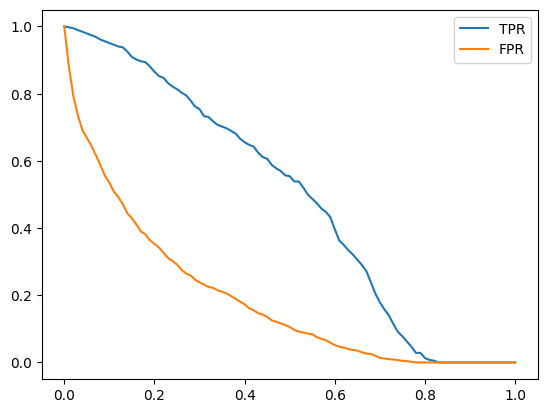

In [47]:
plt.plot(df_scores.threshold,df_scores.tpr,label = 'TPR')
plt.plot(df_scores.threshold,df_scores.fpr,label = 'FPR')
plt.legend()

### Random Model

In [41]:
np.random.seed(1)
y_rand = np.random.uniform(0,1,len(y_val))

In [42]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [43]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
        tp = (actual_positive & predict_positive).sum()
        tn = (actual_negative & predict_negative).sum()
        fp = (actual_negative & predict_positive).sum()
        fn = (actual_positive & predict_negative).sum()
        scores.append((t,tp,fp,fn,tn))
    columns = ['threshold','tp','fp','fn','tn']
    df_scores = pd.DataFrame(scores,columns = columns)
    df_scores['tpr'] = df_scores.tp/(df_scores.tp+df_scores.fn)
    df_scores['fpr'] = df_scores.fp/(df_scores.fp+df_scores.tn)
    return df_scores

In [44]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [45]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


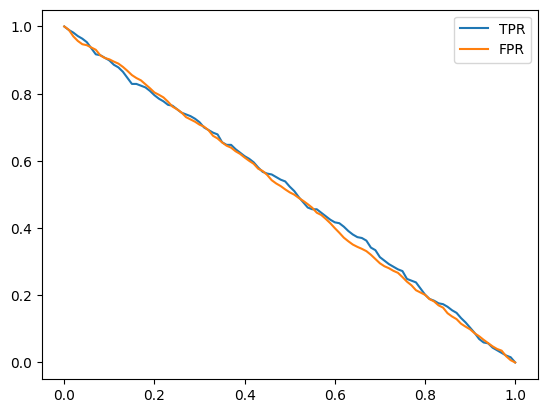

In [46]:
plt.plot(df_rand.threshold,df_rand.tpr,label = 'TPR')
plt.plot(df_rand.threshold,df_rand.fpr,label = 'FPR')
plt.legend()

### Ideal Model

In [49]:
num_neg = (y_val ==0).sum()
num_pos = (y_val ==1).sum()
num_neg,num_pos

(np.int64(1023), np.int64(386))

In [51]:
#repeat, repeats the number of times each element is to be repeated based on the second argument
y_ideal = np.repeat([0,1], [num_neg,num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1], shape=(1409,))

In [52]:
y_ideal_pred = np.linspace(0,1,len(y_val))

In [54]:
((y_ideal_pred>=0.726) == y_ideal).mean()

np.float64(1.0)

In [55]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


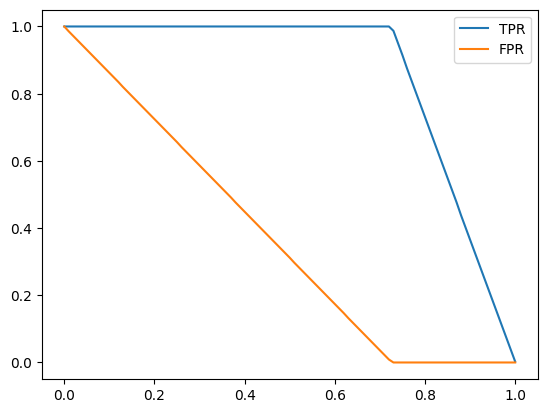

In [56]:
plt.plot(df_ideal.threshold,df_ideal.tpr,label = 'TPR')
plt.plot(df_ideal.threshold,df_ideal.fpr,label = 'FPR')
plt.legend()

### Putting everything together

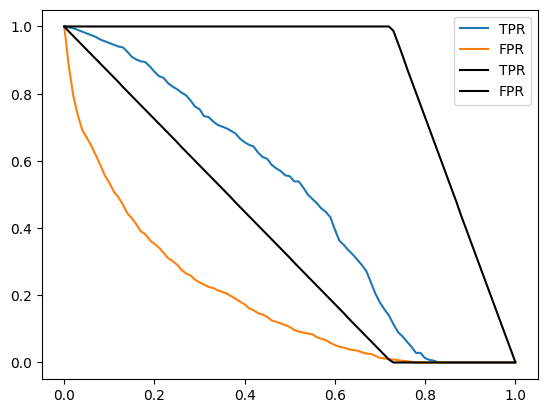

In [59]:
plt.plot(df_scores.threshold,df_scores.tpr,label = 'TPR')
plt.plot(df_scores.threshold,df_scores.fpr,label = 'FPR')

"""
plt.plot(df_rand.threshold,df_rand.tpr,label = 'TPR')
plt.plot(df_rand.threshold,df_rand.fpr,label = 'FPR')
"""

plt.plot(df_ideal.threshold,df_ideal.tpr,label = 'TPR', color = 'black')
plt.plot(df_ideal.threshold,df_ideal.fpr,label = 'FPR', color = 'black')
plt.legend()

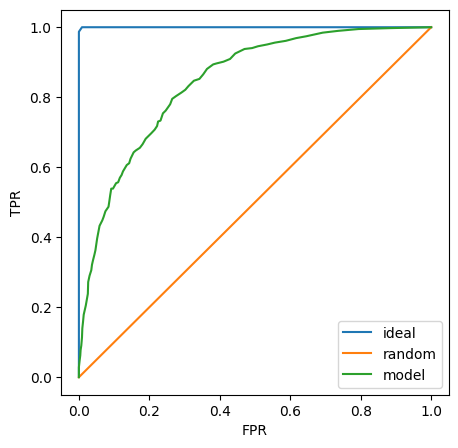

In [66]:
plt.figure(figsize=(5,5))

plt.plot(df_ideal.fpr,df_ideal.tpr, label = 'ideal')
plt.plot([0,1],[0,1], label = 'random')
#plt.plot(df_rand.fpr,df_rand.tpr, label = 'random')
plt.plot(df_scores.fpr,df_scores.tpr, label = 'model')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [67]:
from sklearn.metrics import roc_curve

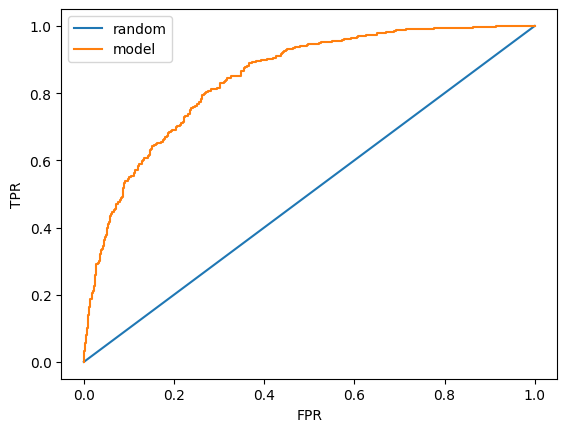

In [73]:
fpr, tpr, thresholds = roc_curve(y_val,y_pred)

#plt.plot(df_ideal.fpr,df_ideal.tpr, label = 'ideal')
plt.plot([0,1],[0,1], label = 'random')
#plt.plot(df_rand.fpr,df_rand.tpr, label = 'random')
plt.plot(fpr, tpr, label = 'model')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()